READING MODELS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math

def get_cmap(n, name='cividis'): #plasma is the best
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

os.chdir(r'/Users/a111/Documents/Neutron Stars')
models=['BSK24_2ord.dat', 'BSK25_2ord.dat', 'BSK26.dat', 'SLY4.dat']
mod=models[3]
data=pd.read_table(mod, delimiter=' ')

n_b = data['nb'] # baryon concentration, [fm^-3]
u = data['u'] # volume factor V/V_c
Z = data['Z'] # equilibrium Z
A = data['A'] # equilibrium masses of nuclei in cluster
A_c = data['A_c'] # equilibrium masses of nuclei in cell




In [2]:
# constants 
h_bar  = 1.054571817e-27    #Planck constant, SGS
m_unit  = 1.66053906660e-24     #atomic mass unit, [g]
eL  = 4.803204712413464e-10    #electron charge, SGS, calculated from alpha_f, hP and CL
erg = 624150.6363094 # [erg in MeV]

# consts for Rij
C_pyc, C_exp, C_pl = 3.90, 2.638, 1.25
D_pyc = C_pyc * 8 * 11.515

def mass_reduc(A_sh): #calc reduced mass of all nucleons in a cell
    m0 = m_unit*A_sh**2.0/(2*A_sh)  #reduced mass [g]
    mu = A_sh**2.0/(2*A_sh) #reduced mass [a.e.m.]
    return m0, mu




PYCNONUCLEAR RATE

In [3]:
def Rij(Z_s, A_s, n_e, u): # func for calculating reaction rates

    m0, mu = mass_reduc(A_s)

    rB = h_bar**2.0/2/m0/Z_s/Z_s/eL/eL # Bohr radius, [cm]
    n_N = n_e / Z_s # [cm^-3]
    la = rB * (n_N/2)**(1/3.0) #lambda parameter, [1]

    a_e = (3/4/np.pi/n_e)**(1/3.0) # [cm^-3]
    coef1, coef2 = -1.6064, -0.9 # 1 - min v_s^{stat}(0), 2 - relax model, max v_s^{stat}(0) (1969, Salpeter-Van Horn) 
    H0 = coef2*eL**2.0*(2*Z_s**(5/3.0) - (Z_s+Z_s)**(5/3.0))/a_e # [erg]
    Epk =  H0*erg # [MeV]
    n_ef = n_e/10**(13*3) # [fm^-3]
    n_Nf = n_ef / Z_s # [fm^-3]
    r0 = (u*3/4/np.pi/n_Nf)**(1/3.0) # [fm]
    R0 = 2*r0

    logr = np.log10(4*D_pyc * (0.5*n_N**2.0) * 8 * (Z_s/((2*Z_s**1/3.0)**3.0)) * (np.pi*(h_bar)**2.0/2/m0) * rB / h_bar / la**C_pl) + 1.05*(mu*R0*Z_s*Z_s)**(1/2.0)*np.log10(math.e) - ((mu*R0**3.0/Z_s/Z_s)**(1/2.0)*Epk/8)*np.log10(math.e) - (C_exp/(la**(1/2.0)))*np.log10(math.e) 
    return logr


ISOCHRONE MAP for Meff = A'

13.521279093128783


/var/folders/bd/0w84qj692kz3d7k9mmwkrhhw0000gn/T/ipykernel_40294/1817273706.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks().astype(int))


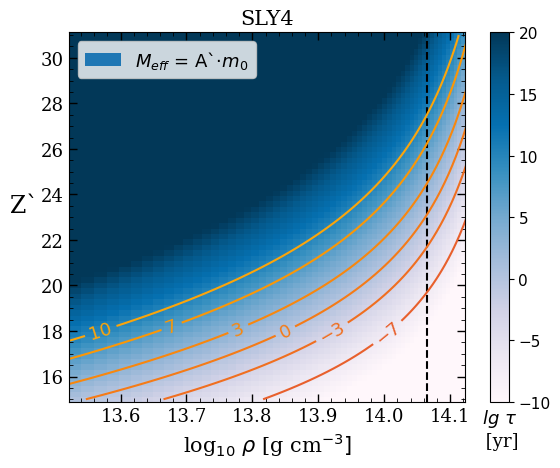

In [6]:
# input parameters
n_e = Z*(n_b*10**(13*3))/A # [cm^-3]
Z_s = np.linspace(15, 31, 34*2) # Non-equilibrium Z

Arr, arr=[], []
for i in range(len(Z_s)):
    for j in range(len(n_e)):
        A_s = Z_s * A[j] / Z[j]
        rij = Rij(Z_s[i], A_s[i], n_e[j], u[j])
        t = np.log10(n_e[j] / Z_s[i]) - (rij) - np.log10(86400*365.2422)
        arr.append(t)
    Arr.append(arr)
    arr=[]




fig, ax = plt.subplots()
map='PuBu'
csfont = {'fontname':'Serif'}

rho=np.zeros(len(n_b))
for r in range(len(n_b)):
    rho[r] = np.log10(n_b[r]*10**(13*3)*m_unit)

plt.pcolor(rho, Z_s, Arr, cmap=map, vmin = np.min(Arr), vmax = np.max(Arr), label='$M_{eff}$ = A`$\cdot m_0$')
im = plt.pcolor(rho, Z_s, Arr, cmap=map, vmin = np.min(Arr), vmax = np.max(Arr))
cbar = plt.colorbar(orientation="vertical", )
cbar.ax.set_xlabel(xlabel='$lg~\\tau$ \n [yr]', **csfont, size=13)
cbar.ax.tick_params(labelsize=11) 
im.figure.axes[1].tick_params(axis="x", labelsize=15)
ax.set_xticklabels(ax.get_xticks().astype(int))

plt.title(mod[0:4], **csfont, size=15)
plt.yticks(np.arange(14, 31, 2), np.arange(14, 31, 2), **csfont, size=13)
plt.clim(-10*np.log10(10), 20*np.log10(10))
plt.xlabel('log$_{10}~\\rho$ [g cm$^{-3}]$', **csfont, size=15)
plt.ylabel('Z`   ', rotation=0, **csfont, size=17)

values=np.arange(13.2, 14.1, 0.1)
plt.xticks(values, ['%.1f' % val for val in values], **csfont, size=13)
plt.xlim([np.log10(0.02*10**(13*3)*m_unit), np.log10(0.08*10**(13*3)*m_unit)])

ax.tick_params(axis = 'both', direction="in", right='on', top='on',  which = 'major', length=6, width=1)
ax.tick_params(axis = 'both', direction="in", right='on', top='on',  which = 'minor', length=3)

import matplotlib.ticker as tck
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())

print(np.log10(0.02*10**(13*3)*m_unit))

rho0=np.log10(0.07*10**(13*3)*m_unit)
ax.axvline(rho0, linestyle='--', color='k')
ax.legend(fontsize=13, loc='upper left')

import matplotlib.colors
levels = np.array([-7, -3, 0, 3, 7, 10])*np.log10(10)
manual_locations = [(14, 18.1), (13.92, 18), (13.85, 18), (13.78, 18), (13.68, 18), (13.57, 18)]
cnt = ax.contour(rho, Z_s, Arr, levels=np.round(levels), cmap='inferno', vmin = np.min(Arr)*4, vmax = np.max(Arr)/7.9)
ax.clabel(cnt, inline=True, fontsize=13, manual=manual_locations)
norm= matplotlib.colors.Normalize(vmin=cnt.cvalues.min(), vmax=cnt.cvalues.min()+0.3)
sm = plt.cm.ScalarMappable(norm=norm, cmap = cnt.cmap)
sm.set_array([])


ISOCHRONE MAP for Meff = Z'

13.521279093128783


/var/folders/bd/0w84qj692kz3d7k9mmwkrhhw0000gn/T/ipykernel_29127/2362522823.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks().astype(int))


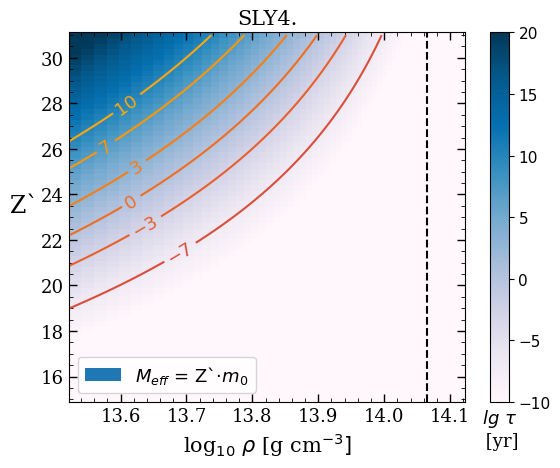

In [487]:
# input parameters
n_e = Z*(n_b*10**(13*3))/A # [cm^-3]
Z_s = np.linspace(15, 31, 34*2) # Non-equilibrium Z

Arr, arr=[], []
A_s = Z_s
for i in range(len(Z_s)):
    for j in range(len(n_e)):
        rij = Rij(Z_s[i], A_s[i], n_e[j], u[j])
        t = np.log10(n_e[j] / Z_s[i]) - (rij) - np.log10(86400*365.2422)
        arr.append(t)
    Arr.append(arr)
    arr=[]




fig, ax = plt.subplots()
map='PuBu'
csfont = {'fontname':'Serif'}

rho=np.zeros(len(n_b))
for r in range(len(n_b)):
    rho[r] = np.log10(n_b[r]*10**(13*3)*m_unit)

plt.pcolor(rho, Z_s, Arr, cmap=map, vmin = np.min(Arr), vmax = np.max(Arr), label='$M_{eff}$ = Z`$\cdot m_0$')
im = plt.pcolor(rho, Z_s, Arr, cmap=map, vmin = np.min(Arr), vmax = np.max(Arr))
cbar = plt.colorbar(orientation="vertical", )
cbar.ax.set_xlabel(xlabel='$lg~\\tau$ \n [yr]', **csfont, size=13)
cbar.ax.tick_params(labelsize=11) 
im.figure.axes[1].tick_params(axis="x", labelsize=15)
ax.set_xticklabels(ax.get_xticks().astype(int))

plt.title(mod[0:4], **csfont, size=15)
plt.yticks(np.arange(14, 31, 2), np.arange(14, 31, 2), **csfont, size=13)
plt.clim(-10*np.log10(10), 20*np.log10(10))
plt.xlabel('log$_{10}~\\rho$ [g cm$^{-3}]$', **csfont, size=15)
plt.ylabel('Z`   ', rotation=0, **csfont, size=17)

values=np.arange(13.2, 14.1, 0.1)
plt.xticks(values, ['%.1f' % val for val in values], **csfont, size=13)
plt.xlim([np.log10(0.02*10**(13*3)*m_unit), np.log10(0.08*10**(13*3)*m_unit)])

ax.tick_params(axis = 'both', direction="in", right='on', top='on',  which = 'major', length=6, width=1)
ax.tick_params(axis = 'both', direction="in", right='on', top='on',  which = 'minor', length=3)

import matplotlib.ticker as tck
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())

print(np.log10(0.02*10**(13*3)*m_unit))

rho0=np.log10(0.07*10**(13*3)*m_unit)
ax.axvline(rho0, linestyle='--', color='k')
ax.legend(fontsize=13, loc='lower left')

import matplotlib.colors
levels = np.array([-7, -3, 0, 3, 7, 10])*np.log10(10)
manual_locations = [
    (13.7, 21), (13.65, 22), (13.63, 25), (13.61, 24), (13.58, 26), (13.56, 30)]
cnt = ax.contour(rho, Z_s, Arr, levels=np.round(levels), cmap='inferno', vmin = np.min(Arr)*2, vmax = np.max(Arr)/5.5)
ax.clabel(cnt, inline=True, fontsize=13, manual=manual_locations)
norm= matplotlib.colors.Normalize(vmin=cnt.cvalues.min(), vmax=cnt.cvalues.min()+0.3)
sm = plt.cm.ScalarMappable(norm=norm, cmap = cnt.cmap)
sm.set_array([])
#ax.legend(loc='best', prop={'size': 12})

ISOCHRONE MAP for Meff = Ac'

13.521279093128783


/var/folders/bd/0w84qj692kz3d7k9mmwkrhhw0000gn/T/ipykernel_29127/828659516.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks().astype(int))


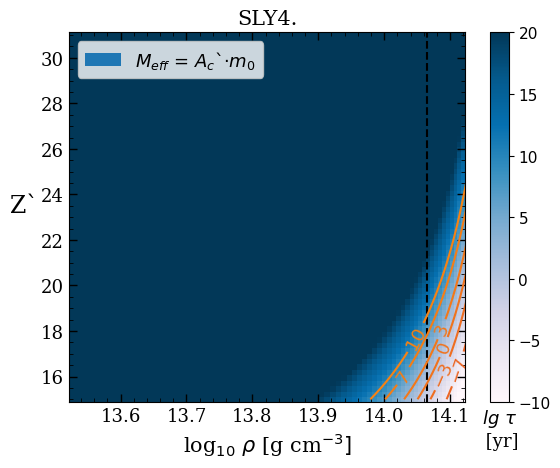

In [489]:
# input parameters
n_e = Z*(n_b*10**(13*3))/A # [cm^-3]
Z_s = np.linspace(15, 31, 34*2) # Non-equilibrium Z

Arr, arr=[], []
for i in range(len(Z_s)):
    for j in range(len(n_e)):
        A_cs = Z_s * A_c[j] / Z[j]
        rij = Rij(Z_s[i], A_cs[i], n_e[j], u[j])
        t = np.log10(n_e[j] / Z_s[i]) - (rij) - np.log10(86400*365.2422)
        arr.append(t)
    Arr.append(arr)
    arr=[]




fig, ax = plt.subplots()
map='PuBu'
csfont = {'fontname':'Serif'}

rho=np.zeros(len(n_b))
for r in range(len(n_b)):
    rho[r] = np.log10(n_b[r]*10**(13*3)*m_unit)

plt.pcolor(rho, Z_s, Arr, cmap=map, vmin = np.min(Arr), vmax = np.max(Arr), label='$M_{eff}$ = $A_{c}$`$\cdot m_0$')
im = plt.pcolor(rho, Z_s, Arr, cmap=map, vmin = np.min(Arr), vmax = np.max(Arr))
cbar = plt.colorbar(orientation="vertical", )
cbar.ax.set_xlabel(xlabel='$lg~\\tau$ \n [yr]', **csfont, size=13)
cbar.ax.tick_params(labelsize=11) 
im.figure.axes[1].tick_params(axis="x", labelsize=15)
ax.set_xticklabels(ax.get_xticks().astype(int))

plt.title(mod[0:4], **csfont, size=15)
plt.yticks(np.arange(14, 31, 2), np.arange(14, 31, 2), **csfont, size=13)
plt.clim(-10*np.log10(10), 20*np.log10(10))
plt.xlabel('log$_{10}~\\rho$ [g cm$^{-3}]$', **csfont, size=15)
plt.ylabel('Z`   ', rotation=0, **csfont, size=17)

values=np.arange(13.2, 14.1, 0.1)
plt.xticks(values, ['%.1f' % val for val in values], **csfont, size=13)
plt.xlim([np.log10(0.02*10**(13*3)*m_unit), np.log10(0.08*10**(13*3)*m_unit)])

ax.tick_params(axis = 'both', direction="in", right='on', top='on',  which = 'major', length=6, width=1)
ax.tick_params(axis = 'both', direction="in", right='on', top='on',  which = 'minor', length=3)

import matplotlib.ticker as tck
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())

print(np.log10(0.02*10**(13*3)*m_unit))

rho0=np.log10(0.07*10**(13*3)*m_unit)
ax.axvline(rho0, linestyle='--', color='k')
ax.legend(fontsize=13, loc='upper left')

import matplotlib.colors
levels = np.array([-7, -3, 0, 3, 7, 10])*np.log10(10)
manual_locations = [
    (14.115, 16.3), (14.099, 16.), (14.09, 17.3), (14.085, 18.1), (14.03, 16), (14.03, 18)]
cnt = ax.contour(rho, Z_s, Arr, levels=np.round(levels), cmap='inferno', vmin = np.min(Arr)*10, vmax = np.max(Arr)/4.3)
ax.clabel(cnt, inline=True, fontsize=13, manual=manual_locations)
norm= matplotlib.colors.Normalize(vmin=cnt.cvalues.min(), vmax=cnt.cvalues.min()+0.3)
sm = plt.cm.ScalarMappable(norm=norm, cmap = cnt.cmap)
sm.set_array([])

ISOCHRONE MAP for Meff = A' - (Ac' - A')*u/(1-u)

13.521279093128783


/var/folders/bd/0w84qj692kz3d7k9mmwkrhhw0000gn/T/ipykernel_29127/1138334889.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks().astype(int))


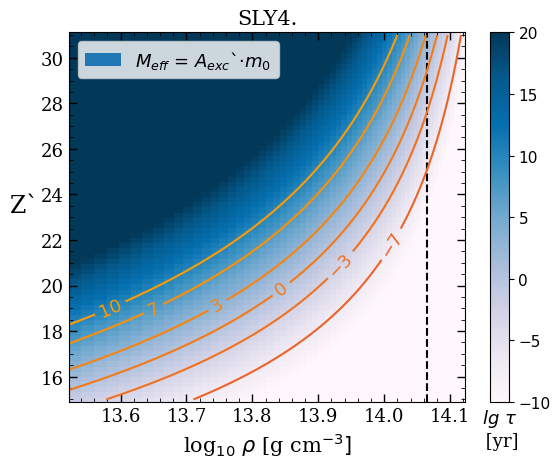

In [493]:
# input parameters
n_e = Z*(n_b*10**(13*3))/A # [cm^-3]
Z_s = np.linspace(15, 31, 18*4) # Non-equilibrium Z

Arr, arr=[], []
for i in range(len(Z_s)):
    for j in range(len(n_e)):
        A_exc = (A[j] - (A_c[j] - A[j])*u[j]/(1-u[j]))*Z_s/Z[j]
        rij = Rij(Z_s[i], A_exc[i], n_e[j], u[j])
        t = np.log10(n_e[j] / Z_s[i]) - (rij) - np.log10(86400*365.2422)
        arr.append(t)
    Arr.append(arr)
    arr=[]




fig, ax = plt.subplots()
map='PuBu'
csfont = {'fontname':'Serif'}

rho=np.zeros(len(n_b))
for r in range(len(n_b)):
    rho[r] = np.log10(n_b[r]*10**(13*3)*m_unit)

plt.pcolor(rho, Z_s, Arr, cmap=map, vmin = np.min(Arr), vmax = np.max(Arr), label='$M_{eff}$ = $A_{exc}$`$\cdot m_0$')
im = plt.pcolor(rho, Z_s, Arr, cmap=map, vmin = np.min(Arr), vmax = np.max(Arr))
cbar = plt.colorbar(orientation="vertical", )
cbar.ax.set_xlabel(xlabel='$lg~\\tau$ \n [yr]', **csfont, size=13)
cbar.ax.tick_params(labelsize=11) 
im.figure.axes[1].tick_params(axis="x", labelsize=15)
ax.set_xticklabels(ax.get_xticks().astype(int))

plt.title(mod[0:4], **csfont, size=15)
plt.yticks(np.arange(14, 31, 2), np.arange(14, 31, 2), **csfont, size=13)
plt.clim(-10*np.log10(10), 20*np.log10(10))
plt.xlabel('log$_{10}~\\rho$ [g cm$^{-3}]$', **csfont, size=15)
plt.ylabel('Z`   ', rotation=0, **csfont, size=17)

values=np.arange(13.2, 14.1, 0.1)
plt.xticks(values, ['%.1f' % val for val in values], **csfont, size=13)
plt.xlim([np.log10(0.02*10**(13*3)*m_unit), np.log10(0.08*10**(13*3)*m_unit)])

ax.tick_params(axis = 'both', direction="in", right='on', top='on',  which = 'major', length=6, width=1)
ax.tick_params(axis = 'both', direction="in", right='on', top='on',  which = 'minor', length=3)

import matplotlib.ticker as tck
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())

print(np.log10(0.02*10**(13*3)*m_unit))

rho0=np.log10(0.07*10**(13*3)*m_unit)
ax.axvline(rho0, linestyle='--', color='k')
ax.legend(fontsize=13, loc='upper left')

import matplotlib.colors
levels = np.array([-7, -3, 0, 3, 7, 10])*np.log10(10)
manual_locations = [(14, 22), (13.93, 21), (13.84, 20), (13.75, 19), (13.65, 19), (13.57, 20)]
cnt = ax.contour(rho, Z_s, Arr, levels=np.round(levels), cmap='inferno', vmin = np.min(Arr)*4, vmax = np.max(Arr)/6.2)
ax.clabel(cnt, inline=True, fontsize=13, manual=manual_locations)
norm= matplotlib.colors.Normalize(vmin=cnt.cvalues.min(), vmax=cnt.cvalues.min()+0.3)
sm = plt.cm.ScalarMappable(norm=norm, cmap = cnt.cmap)
sm.set_array([])

4 plots in one